In [1]:
import warnings
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.plot import heatmap
from graspy.simulations import er_np, sbm
from graspy.utils import symmetrize
from joblib import Parallel, delayed
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu

warnings.filterwarnings("ignore")
%matplotlib inline

In [33]:
def generate_pop(m, loc=0, block_1=5, block_2=15):
    scale = 1/2.576
    total_nodes = block_1 + block_2

    arrs  = []
    for _ in np.arange(m):
        arr = np.zeros((total_nodes, total_nodes))
        for i in range(total_nodes):
            for j in range(i + 1, total_nodes):
                if (i < block_1) and (j < block_1):
                    value = np.random.normal(loc, scale)
                    while (value > 1) or (value < -1):
                        value = np.random.normal(loc, scale)
                    arr[i, j] = value
                else:
                    value = np.random.normal(0, scale)
                    while (value > 1) or (value < -1):
                        value = np.random.normal(0, scale)
                    arr[i, j] = value
        arrs.append(symmetrize(arr, method='triu'))
        
    out = np.stack(arrs)
    return out

def generate_data(m, delta=0, seed=None):
    np.random.seed(seed)
    
    pop1 = generate_pop(m=m, loc=0)
    pop2 = generate_pop(m=m, loc=delta)
    
    return pop1, pop2

def compute_statistic(test, pop1, pop2):
    if test.__name__ == 'ttest_ind':
        test_statistics, _ = ttest_ind(pop1, pop2, axis=0)
        np.nan_to_num(test_statistics, copy=False)
    else:
        n = pop1.shape[-1]
        test_statistics = np.zeros((n, n))
        pvals = np.zeros((n, n))
        
        for i in range(n):
            for j in range(i, n):
                x_ij = pop1[:, i, j]
                y_ij = pop2[:, i, j]

                if np.array_equal(x_ij, y_ij):
                    test_statistics[i, j] = -100
                    pvals[i, j] = 1
                else:
                    tmp, pval = test(x_ij, y_ij)
                    test_statistics[i, j] = tmp
                    pvals[i, j] = pval
            
        test_statistics = symmetrize(test_statistics)
        pvals = symmetrize(pvals)
    
    return test_statistics, pvals

def compute_pr_at_k(different_n, k, test_statistics, test):
    n = test_statistics.shape[0]
    labels = np.zeros((n, n))
    labels[0:different_n, 0:different_n] = 1
    
    triu_idx = np.triu_indices_from(test_statistics, k=1)
    test_statistics_ = test_statistics[triu_idx]
    labels_ = labels[triu_idx]
    
    if test.__name__ == 'ttest_ind':
        idx = np.argsort(test_statistics_)[::-1]
    else:
        idx = np.argsort(test_statistics_)
    sorted_labels = labels_[idx]
    
    precision_at_k = sorted_labels[:k].mean()
    recall_at_k = sorted_labels[:k].sum() / sorted_labels.sum()
    
    return precision_at_k, recall_at_k

def compute_trustworthiness(pvals):
    idx = np.triu_indices(pvals.shape[0], k=1)
    res = pvals[idx]
    
    fraction_correct = (res <=0.05).mean()
    all_correct = np.all(res <= 0.05)
    
    return fraction_correct, all_correct

In [3]:
def run_experiment(m, delta, seed, reps):
    tests = ttest_ind, wilcoxon, mannwhitneyu
    
    precisions = []
    recalls = []
    
    for i in range(reps):
        tmp_precisions = []
        tmp_recalls = [] 
        pop1, pop2 = generate_data(m = m, delta=delta, seed = seed+i)
        
        for test in tests:
            test_statistics = compute_statistic(test, pop1, pop2)
            
            for k in range(1, 11):
                precision, recall = compute_pr_at_k(5, k, test_statistics)
                tmp_precisions.append(precision)
                tmp_recalls.append(recall)

        precisions.append(tmp_precisions)
        recalls.append(tmp_recalls)
            
    precisions = np.array(precisions).mean(axis=0)
    recalls = np.array(recalls).mean(axis=0)
    
    to_append = [delta, m, *precisions, *recalls]

    return to_append

In [4]:
deltas = np.linspace(0, 1, 100)
ms = np.linspace(10, 1000, 100)
reps=100

In [5]:
args = [(m, delta, seed*reps, reps) for seed, (m, delta) in enumerate(product(ms, deltas))]

res = Parallel(n_jobs=-2, verbose=1)(
    delayed(run_experiment)(
        *arg
    ) for arg in args
)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 95 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-2)]: Done 260 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 610 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-2)]: Done 1060 tasks      | elapsed:  9.3min


KeyboardInterrupt: 

In [6]:
cols =  [
    'delta', 
    'm', 
    *[f"{test.__name__}_precision_at_{k}" for test in [ttest_ind, wilcoxon, mannwhitneyu]  for k in range(1, 11)], 
    *[f"{test.__name__}_recall_at_{k}" for test in [ttest_ind, wilcoxon, mannwhitneyu] for k in range(1, 11)]]
res_df = pd.DataFrame(res, columns = cols) 

In [7]:
res_df

,delta,m,ttest_ind_precision_at_1,ttest_ind_precision_at_2,ttest_ind_precision_at_3,ttest_ind_precision_at_4,ttest_ind_precision_at_5,ttest_ind_precision_at_6,ttest_ind_precision_at_7,ttest_ind_precision_at_8,...,mannwhitneyu_recall_at_1,mannwhitneyu_recall_at_2,mannwhitneyu_recall_at_3,mannwhitneyu_recall_at_4,mannwhitneyu_recall_at_5,mannwhitneyu_recall_at_6,mannwhitneyu_recall_at_7,mannwhitneyu_recall_at_8,mannwhitneyu_recall_at_9,mannwhitneyu_recall_at_10
0,0.000000,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
1,0.010101,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
2,0.020202,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
3,0.030303,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
4,0.040404,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
5,0.050505,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
6,0.060606,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
7,0.070707,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
8,0.080808,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
9,0.090909,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0


In [16]:
res_df.to_csv("j1c-experiment2-results.csv", index=False)

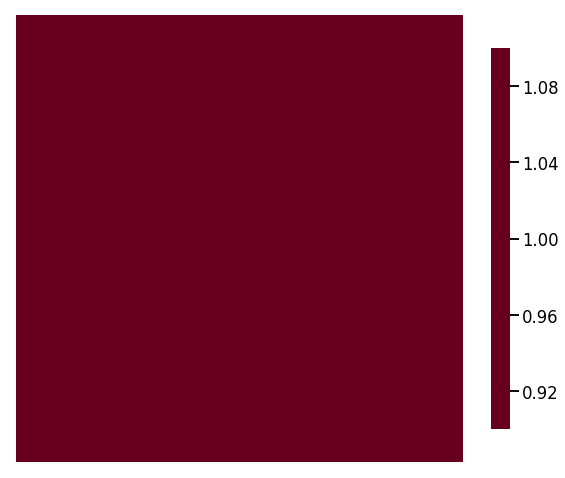

In [17]:
heatmap(res_df.ttest_ind_precision_at_10.values.reshape(100, -1))

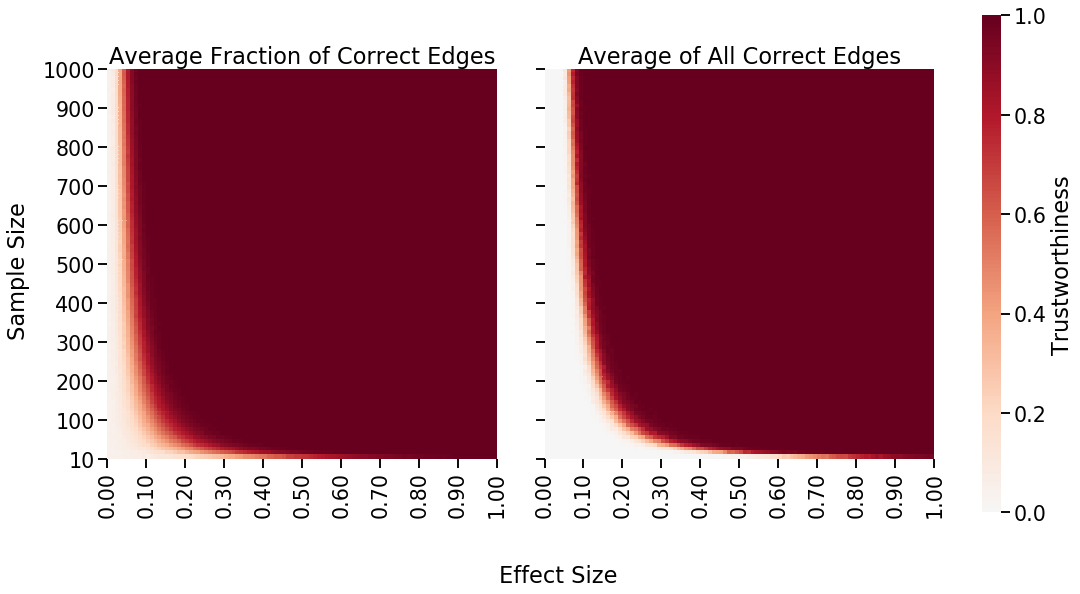

In [17]:
samples = np.arange(0, 1001, 100)
samples[0] += 10
samples = [str(i) for i in samples]

fmt = lambda x: "{:.2f}".format(x)
with sns.plotting_context('talk', font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 0.05]}, figsize=(15, 8))
    
    sns.heatmap(
        np.flipud(res_df.fraction_correct.values.reshape(100, -1)),
        ax = ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[fmt(i) for i in np.linspace(0, 1, 101)[::10]],
        yticklabels=samples,
        cbar_ax=ax[-1]
    )
    ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1]+1, 10))
    ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0]+1, 10)[::-1])
    ax[0].set_title("Average Fraction of Correct Edges")
    
    sns.heatmap(
        np.flipud(res_df.all_correct.values.reshape(100, -1)),
        ax = ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7, label='Trustworthiness'),
        xticklabels=[fmt(i) for i in np.linspace(0, 1, 101)[::10]],
        cbar_ax=ax[-1]
    )
    ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("Average of All Correct Edges")


    fig.text(-0.01, 0.5, "Sample Size", va='center', rotation='vertical')
    fig.text(0.5, -0.03, "Effect Size", va='center', ha='center')
    
    fig.tight_layout()